<a name="top"> <h1>01. ML Models</h1> <a>

<p>Análisis de sentimiento: Tweets<br />
<strong>Trabajo de Fin de Master</strong><br />
<strong>Master Universitario en Ciencia de Datos</strong></p>

<p>&nbsp;</p>

<p style="text-align:right">V&iacute;ctor Viloria V&aacute;zquez (<em>victor.viloria@cunef.edu</em>)</p>


<hr style="border:1px solid gray">

### Estructura

[Introducción](#introduccion) 

[1. Librerias utilizadas y funciones](#librerias) 

[2. Lectura del dataframe y preparación de los datos](#lectura) 

   - 2.1. Lectura del DF
   - 2.2. Preparación de los datos

[3. Evaluación de los modelos ](#modelos) 

   - 3.1. Support Vector Classifier
   - 3.2. Multinomial Naive Bayes
   - 3.3. Random Forest
   - 3.4. Logistic Regression


[4. Resultado de los modelos](#evaluacion) 


[5. Calibración del modelo](#calibracion)


<hr style="border:1px solid gray">

# <a name="librerias"> 1. Librerias utilizadas y funciones <a>


Importamos las librerias a utilizar para el preprocesamiento:

In [2]:
# Import basic libraries.

import pandas as pd
import numpy as np
import string
import pickle
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import seaborn as sns

# Import ML libraries.

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score   
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score, make_scorer

# Import libraries for evaluation.

from sklearn.model_selection import GridSearchCV

# <a name="lectura"> 2. Lectura del dataframe y preparación de los datos<a>


## 2.1. Lectura del DF

In [3]:
#Import parquet file.

tweets = pd.read_parquet('../../data/processed/tweets.parquet')


# Show the head of the dataframe.

tweets.head()

,text,sentiment,SentimentText_clean
0,id have responded if i were going,0,id responded going
1,sooo sad i will miss you here in san diego,2,sooo sad miss san diego
2,my boss is bullying me,2,boss bullying
3,what interview leave me alone,2,interview leave alone
4,sons of why couldnt they put them on the rel...,2,sons couldnt put releases already bought


## 2.2. Preparación de los datos

Preparamos los datos para que puedan ser introducidos dentro de los modelos, separando en X el texto y en Y las puntuaciones.

In [4]:
# Define X and y.

X = tweets.SentimentText_clean
y = tweets.sentiment

# Split into train and test.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# <a name="modelos"> 3. Evaluación de los modelos<a>


## 3.1. Support Vector Classifier

In [59]:
# Set up the pipeline.

tfidf = TfidfVectorizer(stop_words="english",max_df=0.99,min_df=0.01)
svc = SVC(probability=True)
model = make_pipeline(tfidf, svc)

# Training the model.

model.fit(x_train, y_train)

# Prediction.
preds= model.predict(x_test)
predict_probabilities = model.predict_proba(x_test)

In [60]:
# Evaluation
print(classification_report(y_test,preds))

# Print: the accuracy score.

print("Accuracy:",metrics.accuracy_score(y_test, preds))

# Print: F-2.

print("F2:",fbeta_score(y_test, preds, beta=2, average='weighted'))

              precision    recall  f1-score   support

           0       0.52      0.78      0.63      2252
           1       0.73      0.57      0.64      1719
           2       0.60      0.32      0.41      1526

    accuracy                           0.59      5497
   macro avg       0.62      0.56      0.56      5497
weighted avg       0.61      0.59      0.57      5497

Accuracy: 0.5850463889394215
F2: 0.5740070849633124


<Axes: >

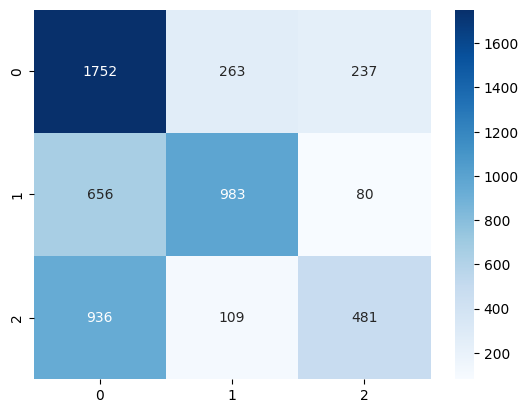

In [61]:
# Confusion matrix.

conf_mat = confusion_matrix(y_test, preds)

# Plot the heatmap.

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')

In [62]:
# Save the model.

pickle.dump(model, open('../../models/svc_model_tweets.pkl', 'wb'))

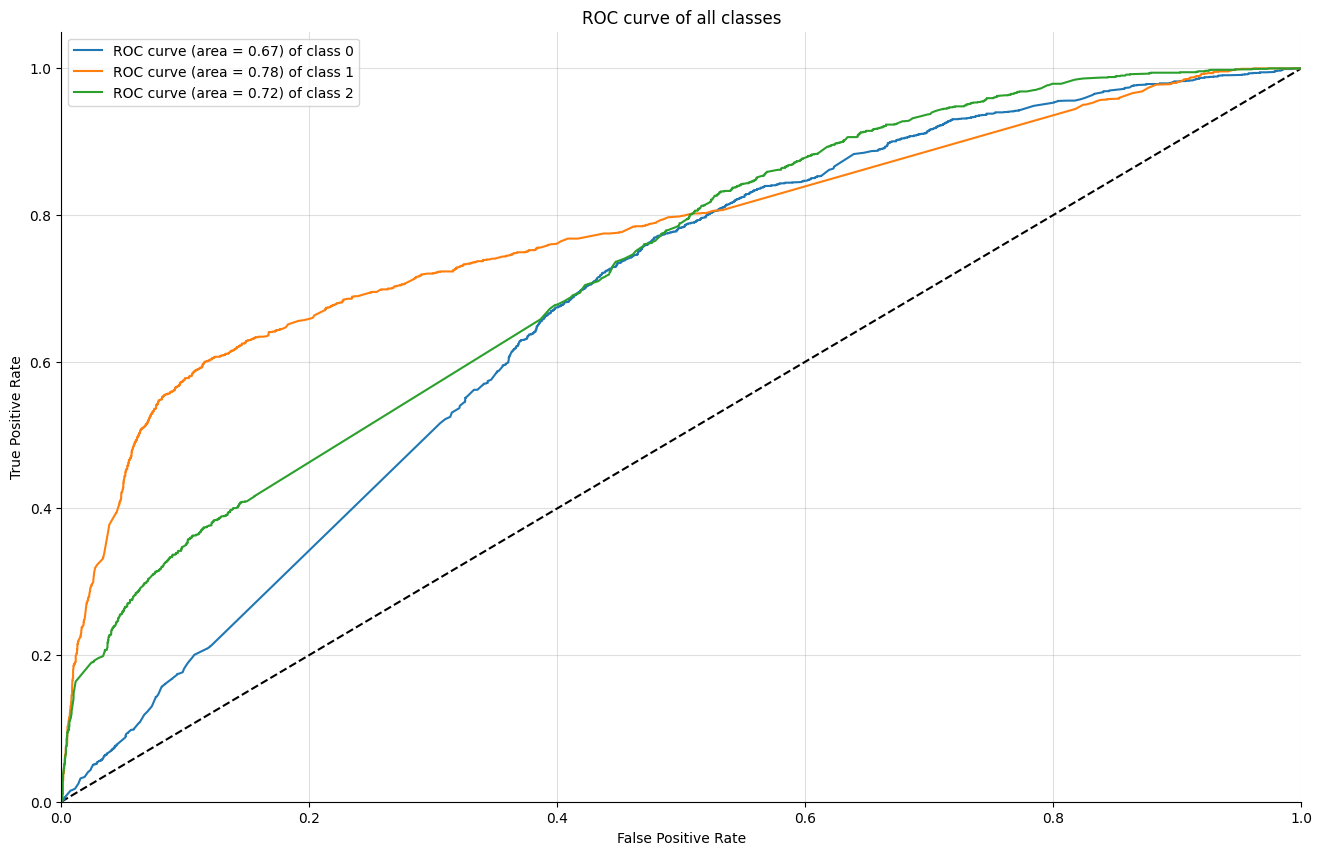

AUC: 0.7235516168610309


In [63]:
# Calculate the AUC.

#Function to plot the ROC curve of a multi-class classifier.

def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    
        y_score = clf.predict_proba(X_test)
        
        # structures
        fpr = dict()
        
        tpr = dict()
        
        roc_auc = dict()
        
        # calculate dummies once
        
        y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
        
        for i in range(n_classes):
                
                fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
                
                roc_auc[i] = auc(fpr[i], tpr[i])
                
        # roc for each class
        
        fig, ax = plt.subplots(figsize=figsize)
        
        ax.plot([0, 1], [0, 1], 'k--')
        
        ax.set_xlim([0.0, 1.0])
        
        ax.set_ylim([0.0, 1.05])
        
        ax.set_xlabel('False Positive Rate')
        
        ax.set_ylabel('True Positive Rate')
        
        ax.set_title('ROC curve of all classes')
        
        for i in range(n_classes):
                
                ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) of class %i' % (roc_auc[i], i))
                
        ax.legend(loc="best")
        
        ax.grid(alpha=.4)
        
        sns.despine()
        
        plt.show()

# Plot the ROC curve.

plot_multiclass_roc(model, x_test, y_test, n_classes=3, figsize=(16, 10))

# Print the AUC.

print("AUC:",roc_auc_score(y_test, predict_probabilities, multi_class='ovr'))

## 3.2. MultinomialNB

In [64]:
# Set up the pipeline.

tfidf = TfidfVectorizer(stop_words="english",max_df=0.99,min_df=0.01)

In [65]:
# Entrenar el modelo
clf = MultinomialNB()

model = make_pipeline(tfidf, clf)
#Training
model.fit(x_train, y_train)

#Prediccion sobre test
preds= model.predict(x_test )
predict_probabilities = model.predict_proba(x_test)


In [66]:
# Evaluation
print(classification_report(y_test,preds))

# Print: the accuracy score.

print("Accuracy:",metrics.accuracy_score(y_test, preds))

# Print: F-2.

print("F2:",fbeta_score(y_test, preds, beta=2, average='weighted'))

              precision    recall  f1-score   support

           0       0.51      0.86      0.64      2252
           1       0.75      0.51      0.61      1719
           2       0.70      0.24      0.35      1526

    accuracy                           0.58      5497
   macro avg       0.65      0.53      0.53      5497
weighted avg       0.64      0.58      0.55      5497

Accuracy: 0.5764962706931054
F2: 0.554672603666725


[[1931  200  121]
 [ 807  877   35]
 [1079   86  361]]


<Axes: >

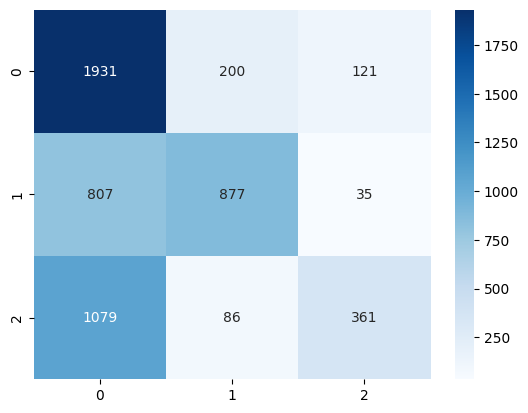

In [67]:
print(confusion_matrix(y_test,preds))

# Confusion matrix.

conf_mat = confusion_matrix(y_test, preds)

# Plot the heatmap.

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')


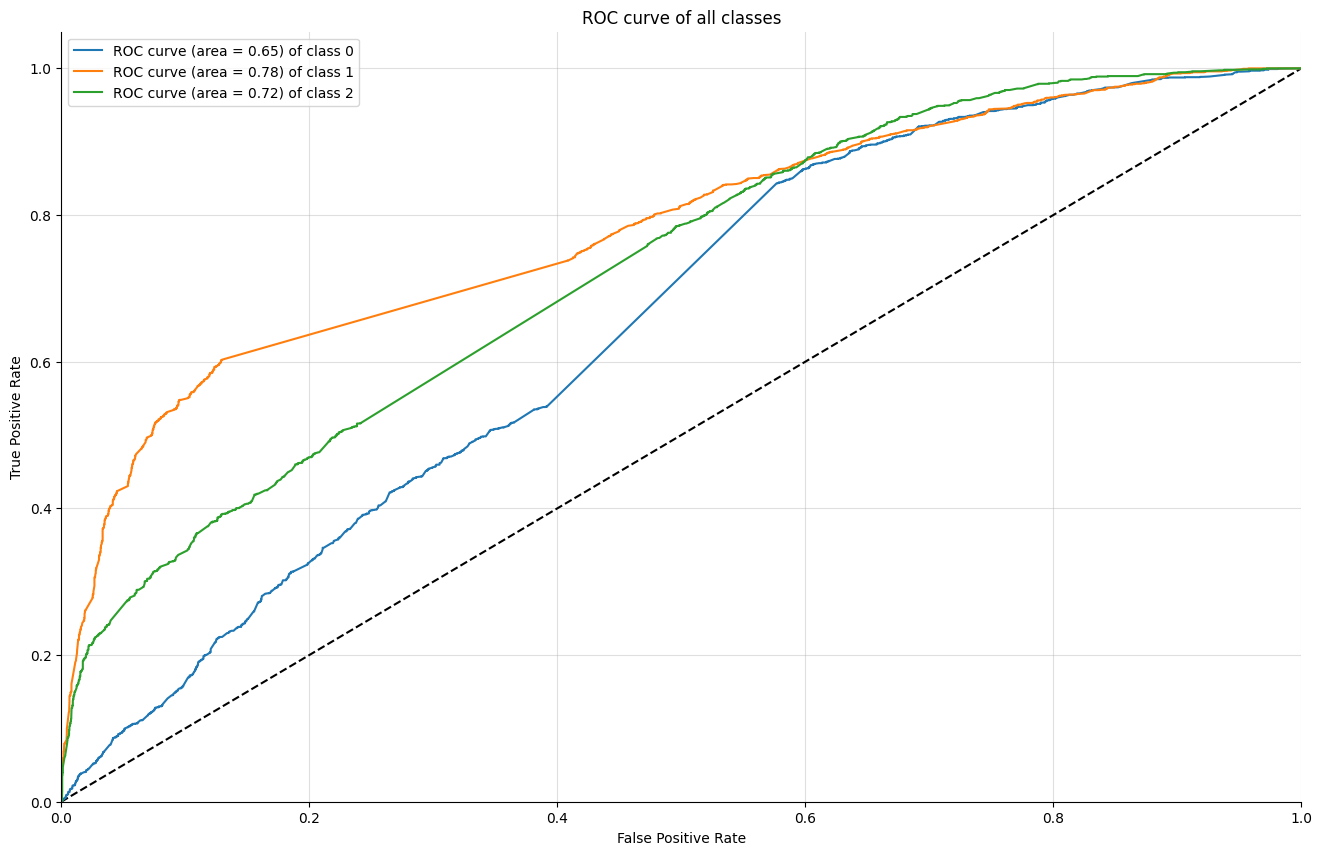

AUC: 0.7174322393934358


In [68]:
# Plot the ROC curve.

plot_multiclass_roc(model, x_test, y_test, n_classes=3, figsize=(16, 10))

# Print the AUC.

print("AUC:",roc_auc_score(y_test, predict_probabilities, multi_class='ovr'))

## 3.3. XGB Classifier

In [10]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    
        y_score = clf.predict_proba(X_test)
        
        # structures
        fpr = dict()
        
        tpr = dict()
        
        roc_auc = dict()
        
        # calculate dummies once
        
        y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
        
        for i in range(n_classes):
                
                fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
                
                roc_auc[i] = auc(fpr[i], tpr[i])
                
        # roc for each class
        
        fig, ax = plt.subplots(figsize=figsize)
        
        ax.plot([0, 1], [0, 1], 'k--')
        
        ax.set_xlim([0.0, 1.0])
        
        ax.set_ylim([0.0, 1.05])
        
        ax.set_xlabel('False Positive Rate')
        
        ax.set_ylabel('True Positive Rate')
        
        ax.set_title('ROC curve of all classes')
        
        for i in range(n_classes):
                
                ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) of class %i' % (roc_auc[i], i))
                
        ax.legend(loc="best")
        
        ax.grid(alpha=.4)
        
        sns.despine()
        
        plt.show()

In [7]:

tfidf = TfidfVectorizer(stop_words="english",max_df=0.99,min_df=0.01)
# Entrenar el modelo

xgb = XGBClassifier()

model = make_pipeline(tfidf, xgb)

#Training

model.fit(x_train, y_train)

#Prediccion sobre test

preds= model.predict(x_test )
predict_probabilities = model.predict_proba(x_test)

In [8]:
# Evaluation
print(classification_report(y_test,preds))

# Print: the accuracy score.

print("Accuracy:",metrics.accuracy_score(y_test, preds))

# Print: F-2.

print("F2:",fbeta_score(y_test, preds, beta=2, average='weighted'))

              precision    recall  f1-score   support

           0       0.52      0.79      0.63      2252
           1       0.72      0.57      0.64      1719
           2       0.62      0.29      0.39      1526

    accuracy                           0.59      5497
   macro avg       0.62      0.55      0.55      5497
weighted avg       0.61      0.59      0.57      5497

Accuracy: 0.5852283063489175
F2: 0.5719204548094313


<Axes: >

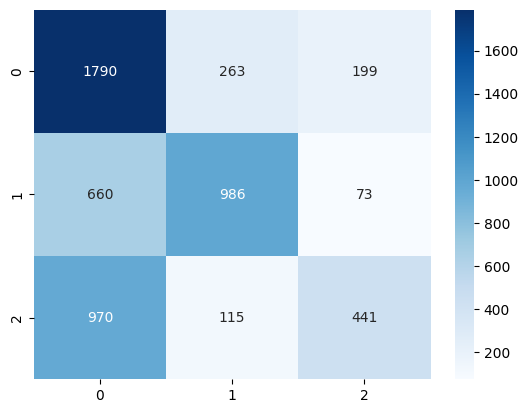

In [12]:
# Confusion matrix.

conf_mat = confusion_matrix(y_test, preds)

# Plot the heatmap.

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')

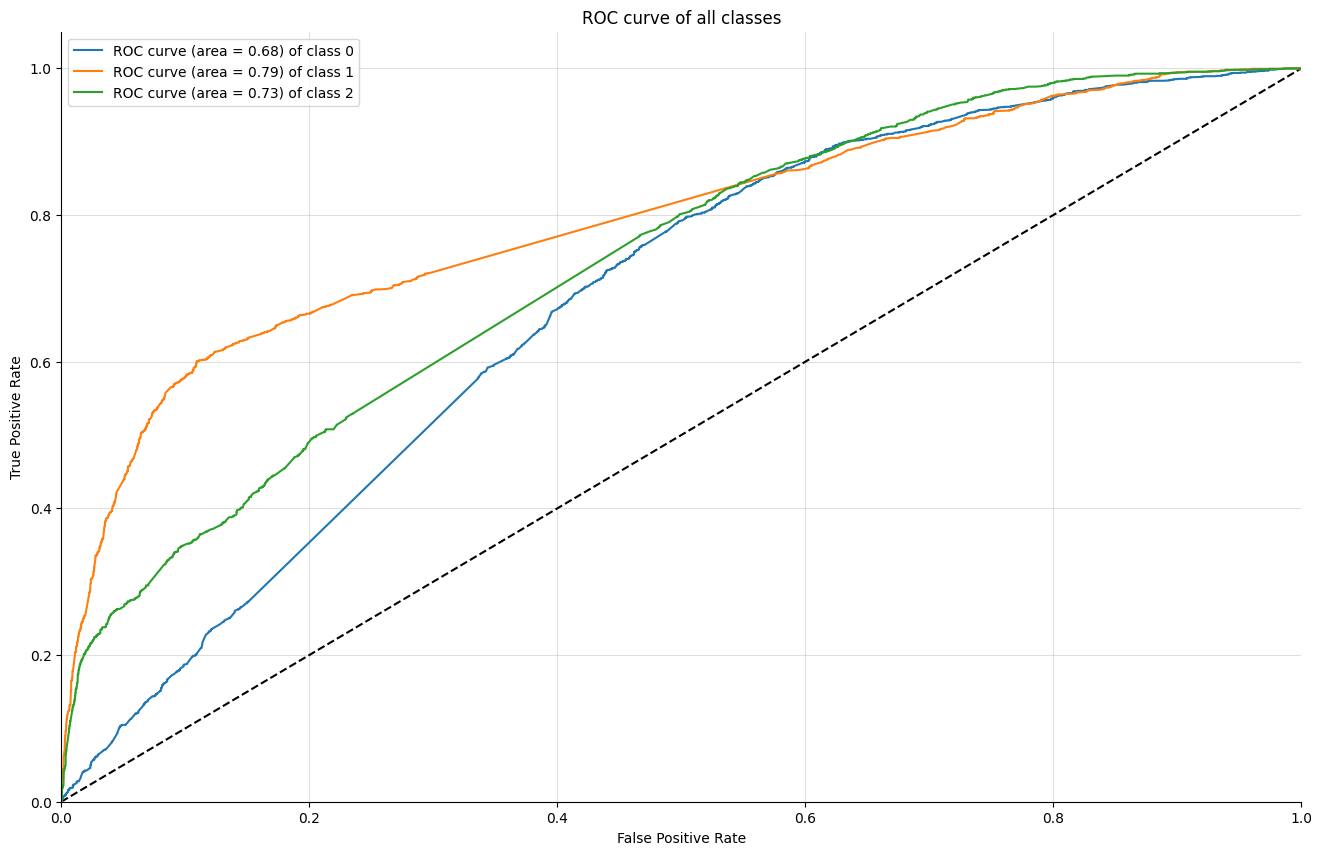

AUC: 0.7339127875256333


In [11]:
# Plot the ROC curve.

plot_multiclass_roc(model, x_test, y_test, n_classes=3, figsize=(16, 10))

# Print the AUC.

print("AUC:",roc_auc_score(y_test, predict_probabilities, multi_class='ovr'))

## 3.4. Random Forest

In [73]:
# Entrenar el modelo

rf = RandomForestClassifier()

model = make_pipeline(tfidf, rf)

#Training

model.fit(x_train, y_train)

#Prediccion sobre test

preds= model.predict(x_test )
predict_probabilities = model.predict_proba(x_test)

In [74]:
# Evaluation
print(classification_report(y_test,preds))

# Print: the accuracy score.

print("Accuracy:",metrics.accuracy_score(y_test, preds))

# Print: F-2.

print("F2:",fbeta_score(y_test, preds, beta=2, average='weighted'))

              precision    recall  f1-score   support

           0       0.53      0.74      0.61      2252
           1       0.70      0.57      0.63      1719
           2       0.56      0.34      0.43      1526

    accuracy                           0.58      5497
   macro avg       0.60      0.55      0.56      5497
weighted avg       0.59      0.58      0.57      5497

Accuracy: 0.5768601055120975
F2: 0.5691677546036367


[[1663  280  309]
 [ 630  984  105]
 [ 865  137  524]]


<Axes: >

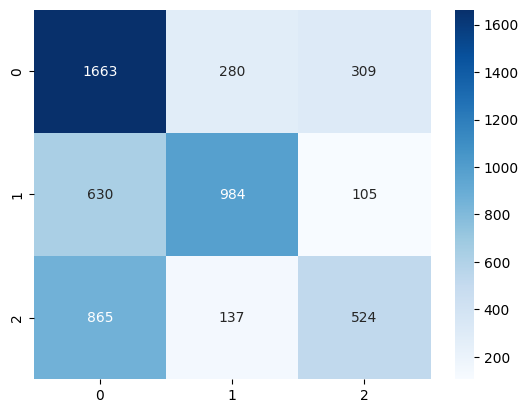

In [75]:
# Confusion matrix.

conf_mat = confusion_matrix(y_test, preds)

# Plot the heatmap.

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')


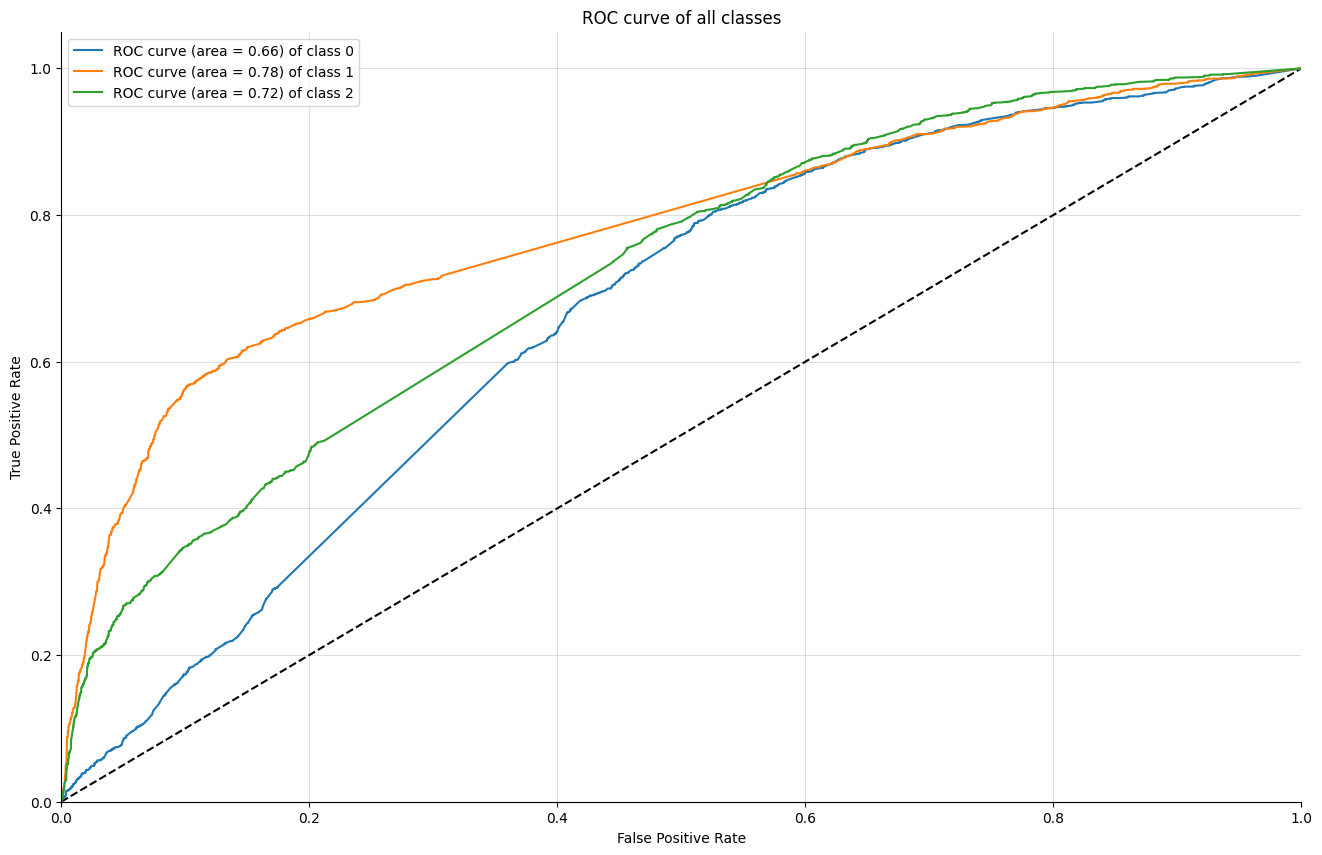

AUC: 0.7211035201285197


In [76]:
# Plot the ROC curve.

plot_multiclass_roc(model, x_test, y_test, n_classes=3, figsize=(16, 10))

# Print the AUC.

print("AUC:",roc_auc_score(y_test, predict_probabilities, multi_class='ovr'))

## 3.5. Logistic Regression

In [77]:
# Entrenar el modelo

lr = LogisticRegression()

model = make_pipeline(tfidf, lr)

#Training

model.fit(x_train, y_train)

#Prediccion sobre test

preds= model.predict(x_test )
predict_probabilities = model.predict_proba(x_test)

In [78]:
# Evaluation
print(classification_report(y_test,preds))

# Print: the accuracy score.

print("Accuracy:",metrics.accuracy_score(y_test, preds))

# Print: F-2.

print("F2:",fbeta_score(y_test, preds, beta=2, average='weighted'))

              precision    recall  f1-score   support

           0       0.52      0.78      0.63      2252
           1       0.73      0.58      0.64      1719
           2       0.60      0.30      0.40      1526

    accuracy                           0.59      5497
   macro avg       0.62      0.55      0.56      5497
weighted avg       0.61      0.59      0.57      5497

Accuracy: 0.585955975986902
F2: 0.5740425799967336


[[1766  265  221]
 [ 645  994   80]
 [ 953  112  461]]


<Axes: >

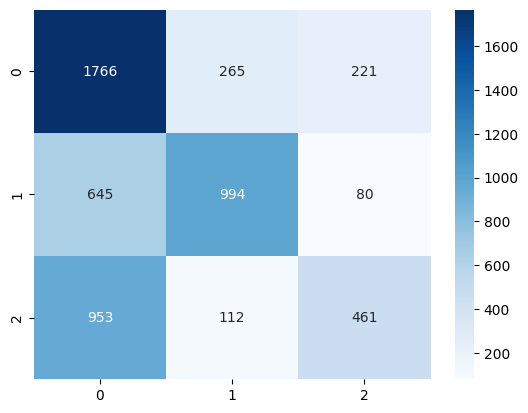

In [79]:
# Confusion matrix.

conf_mat = confusion_matrix(y_test, preds)

# Plot the heatmap.

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')


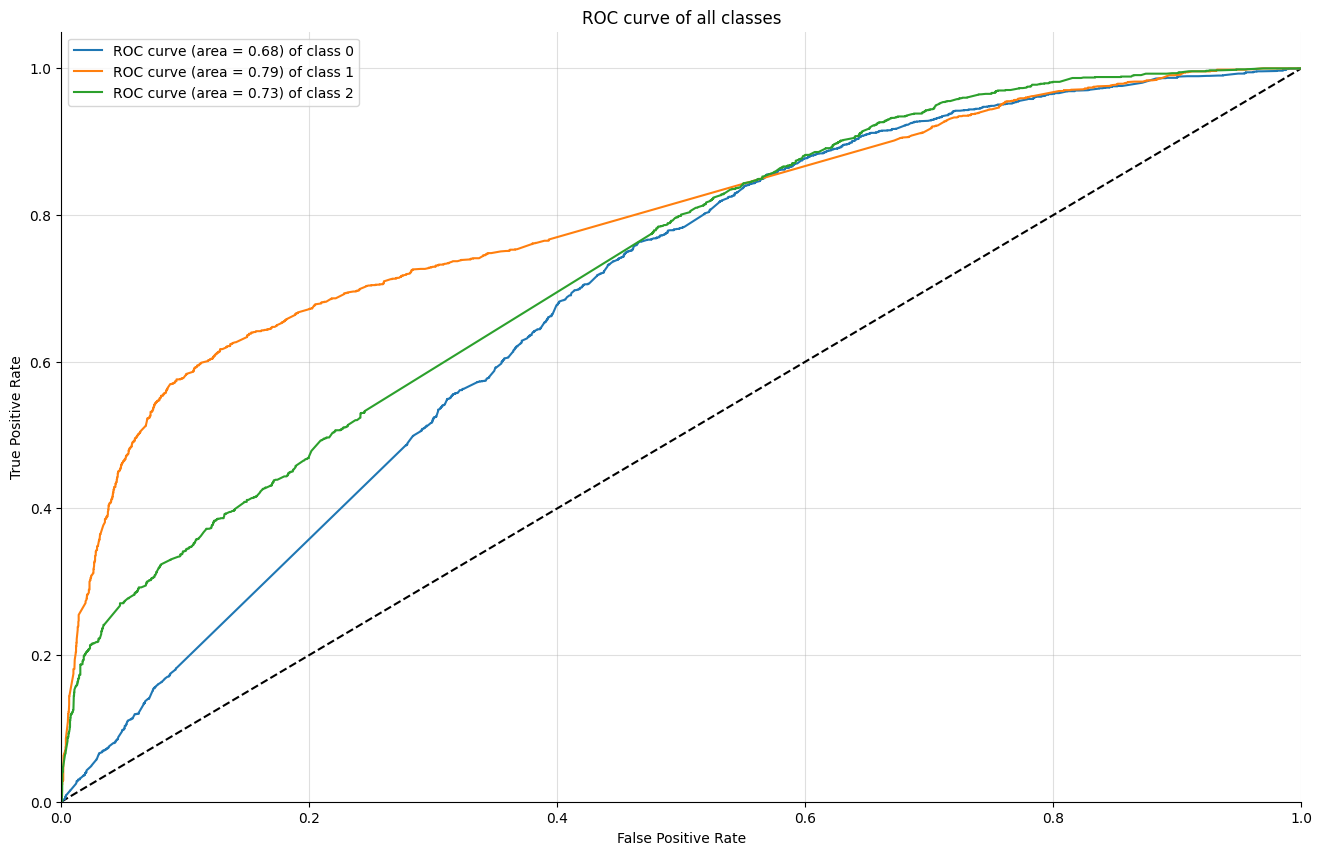

AUC: 0.7349856658362187


In [80]:
# Plot the ROC curve.

plot_multiclass_roc(model, x_test, y_test, n_classes=3, figsize=(16, 10))

# Print the AUC.

print("AUC:",roc_auc_score(y_test, predict_probabilities, multi_class='ovr'))

In [87]:
# Create a table with the results.

results = pd.DataFrame({'Model':['SVC', 'MultinomialNB', 'XGBClassifier', 'RandomForestClassifier', 'LogisticRegression'],
                        'F2 Score':[0.574,0.554,0.571 ,0.569 ,0.574],
                        'AUC':[0.72, 0.71, 0.73, 0.72, 0.73],
                        'Accuracy':[0.585, 0.576, 0.585, 0.576, 0.585]})

# Display the table.

results.sort_values(by='F2 Score', ascending=False).reset_index(drop=True)

,Model,F2 Score,AUC,Accuracy
0,SVC,0.574,0.72,0.585
1,LogisticRegression,0.574,0.73,0.585
2,XGBClassifier,0.571,0.73,0.585
3,RandomForestClassifier,0.569,0.72,0.576
4,MultinomialNB,0.554,0.71,0.576


# <a name="calibracion"> 5. Calibración del Modelo <a>


In [101]:
# Fine-tune the model Logistic Regression.

LR = LogisticRegression()

model = make_pipeline(tfidf, LR)


# Set up the parameters.

param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100], 
              'logisticregression__penalty': ['l1', 'l2'],
              'logisticregression__solver': ['liblinear', 'saga'],
              'logisticregression__max_iter': [100, 1000, 2500, 5000],
              'logisticregression__class_weight': ['balanced', None],
              'logisticregression__multi_class': ['ovr', 'multinomial']
              }


# Set up the grid search.

grid = GridSearchCV(model, param_grid, cv=5)

# Fit the grid search.

grid.fit(x_train, y_train)

# Print the best parameters and the best score.


print("Best parameters: {}".format(grid.best_params_))




Best parameters: {'logisticregression__C': 1, 'logisticregression__class_weight': None, 'logisticregression__max_iter': 100, 'logisticregression__multi_class': 'ovr', 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}


In [108]:
# Prediction.

preds= grid.predict(x_test)

# Evaluation

print(classification_report(y_test,preds))

# Print: the f2 score.

print("F2:",fbeta_score(y_test, preds, beta=2, average='weighted'))

# Print: the accuracy score.

print("Accuracy:",metrics.accuracy_score(y_test, preds))

              precision    recall  f1-score   support

           0       0.52      0.79      0.63      2252
           1       0.73      0.58      0.64      1719
           2       0.62      0.30      0.40      1526

    accuracy                           0.59      5497
   macro avg       0.62      0.56      0.56      5497
weighted avg       0.61      0.59      0.57      5497

F2: 0.5746273482152213
Accuracy: 0.5868655630343824
